# Fase 1: preprocessing & Model Training

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")
pd.set_option('display.max_columns', None)

In [2]:
# Leer el dataset
df = pd.read_csv('../../data/clean/steel_energy_clean.csv')
print("Estructura del dataset:")
df.head(3)

Estructura del dataset:


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,2018-01-01 00:00:00,3.42,3.46,0.0,0.0,70.30,100.0,0.0,WEEKDAY,MONDAY,LIGHT_LOAD,907.000000
1,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900.0,WEEKDAY,MONDAY,LIGHT_LOAD,649.000000
2,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,WEEKDAY,MONDAY,LIGHT_LOAD,497.651857


In [3]:
# Separar variables predictoras (X) y target (y)
target = "Load_Type"
# Ajustar según tu variable objetivo real
y = df['Load_Type']
X = df.drop(columns=[target, 'date'], errors="ignore")

In [4]:
# Dividir en train/test (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
# Definir columnas numéricas y categóricas
cat_cols = list(X.select_dtypes('object').columns)
num_cols = list(X.select_dtypes('number').columns)

In [6]:
# Definir el preprocesamiento
# Generar ColumnTransformer como pipeline general de Preprocesamiento
preprocessing = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

In [7]:
# Crear el pipeline del modelo
rf_model = make_pipeline(preprocessing, RandomForestClassifier(random_state=42))

In [8]:
# Entrenamiento del modelo base
rf_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Usage_kWh',
                                                   'Lagging_Current_Reactive.Power_kVarh',
                                                   'Leading_Current_Reactive_Power_kVarh',
                                                   'CO2(tCO2)',
                                                   'Lagging_Current_Power_Factor',
                                                   'Leading_Current_Power_Factor',
                                                   'NSM', 'mixed_type_col']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['WeekStatus',
                                                   'Day_of_week'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

Clasificación inicial:
              precision    recall  f1-score   support

  LIGHT_LOAD       0.97      0.97      0.97      3656
MAXIMUM_LOAD       0.78      0.81      0.80      1466
 MEDIUM_LOAD       0.83      0.80      0.82      1961

    accuracy                           0.89      7083
   macro avg       0.86      0.86      0.86      7083
weighted avg       0.89      0.89      0.89      7083

Accuracy: 0.890583086262883


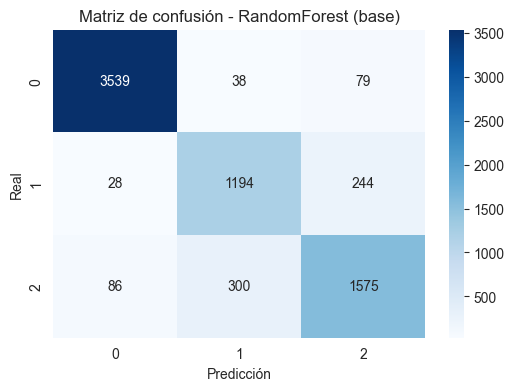

In [9]:
# Evaluación inicial
y_pred = rf_model.predict(X_test)

print("Clasificación inicial:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión - RandomForest (base)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

In [10]:
# BÚSQUEDA DE HIPERPARÁMETROS
param_dist = {
    "randomforestclassifier__n_estimators": [100, 200, 400],
    "randomforestclassifier__max_depth": [10, 20, None],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 4],
    "randomforestclassifier__max_features": ["sqrt", "log2"]
}

# Configurar búsqueda aleatoria
rf_random = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Ejecutar tuning
rf_random.fit(X_train, y_train)

print(" Mejores hiperparámetros encontrados:")
print(rf_random.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
 Mejores hiperparámetros encontrados:
{'randomforestclassifier__n_estimators': 400, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 20}



Reporte de Clasificación:
              precision    recall  f1-score   support

  LIGHT_LOAD       0.97      0.97      0.97      3656
MAXIMUM_LOAD       0.77      0.83      0.80      1466
 MEDIUM_LOAD       0.83      0.79      0.81      1961

    accuracy                           0.89      7083
   macro avg       0.86      0.86      0.86      7083
weighted avg       0.89      0.89      0.89      7083

Accuracy: 0.8907242693773825


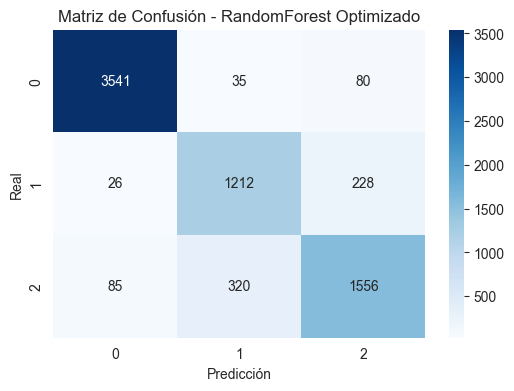

In [11]:
# EVALUACIÓN FINAL
best_model = rf_random.best_estimator_
y_pred = best_model.predict(X_test)

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - RandomForest Optimizado")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

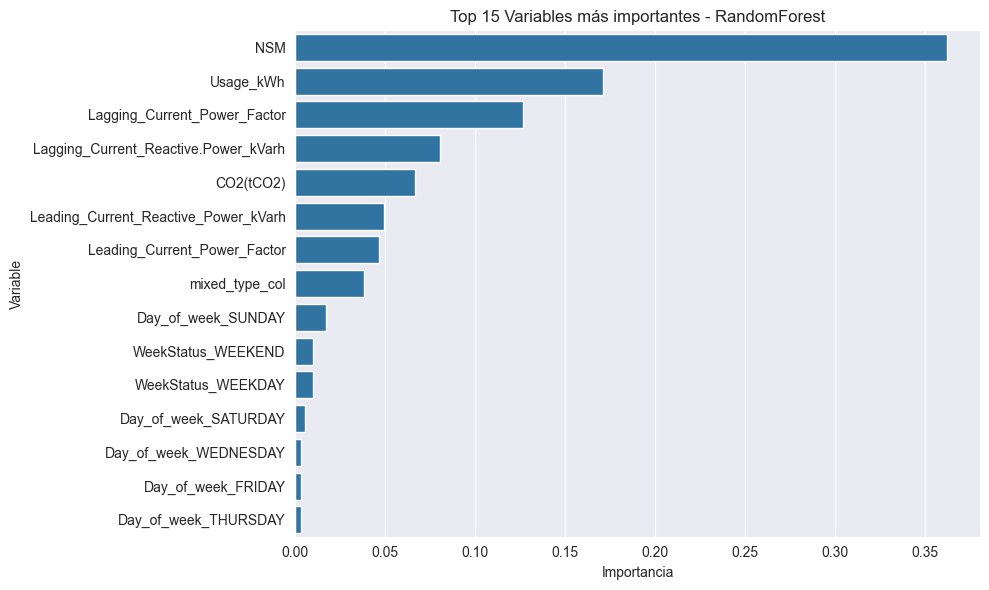

In [12]:
# IMPORTANCIA DE VARIABLES
# Recuperar el modelo interno ya entrenado
rf_final = best_model.named_steps["randomforestclassifier"]

# Recuperar nombres de columnas después del OneHotEncoder
ohe = best_model.named_steps["columntransformer"].named_transformers_["cat"]
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
final_feature_names = np.concatenate([num_cols, encoded_cat_cols])

# Importancias
importances = rf_final.feature_importances_
feature_importances = pd.DataFrame({
    "Feature": final_feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Top 15 variables
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(15), x="Importance", y="Feature")
plt.title("Top 15 Variables más importantes - RandomForest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()